# **本章重点——策略交易订单（下篇）**

####  **1.增加自定义策略绩效分析模块（计算超额收益）**
####  **2.扩充原有的策略回测函数**
####  **3.固定/动态止损单设置的多种方式**
####  **4.一揽子订单实现策略的止盈止损**

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from IPython.display import display
# import datetime
from itertools import chain
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
import numpy as np
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import datetime
import os
from datetime import datetime, timedelta # 增加了时间模块
import quantstats as qs
import talib as ta
from typing import Union
import backtrader.indicators as btind
warnings.filterwarnings("ignore")

## **1.自定义策略绩效分析**

#### 增加超额收益的计算与可视化

In [2]:
def performance_mat(ret_data:pd.DataFrame):
    """
    计算收益率矩阵的各项常用指标：
    '总收益','年化收益率','年化波动率','夏普比率','最大回撤','最大回撤开始日期','最大回撤截止日期','月度胜率'
    
    输入参数 ret_data：形如下面的DataFrame，注意index需要是升序排列，且是datetime格式，不是str格式
    
                    策略	      基准	     超额
    2019-01-02	0.000000	0.000000	0.000000
    2019-01-03	0.000000	-0.004635	0.004656
    2019-01-04	0.000000	0.023846	-0.023290
    2019-01-07	0.000000	0.018391	-0.018059
    2019-01-08	0.000000	-0.002571	0.002578
    ...	...	...	...
    2022-12-26	-0.015485	0.013865	-0.028949
    2022-12-27	0.025465	0.007257	0.018076
    2022-12-28	0.002191	-0.004004	0.006220
    2022-12-29	-0.008016	-0.000801	-0.007221
    2022-12-30	0.009551	0.001206	0.008334
    """
    columns = ret_data.columns
    res = pd.DataFrame(columns=columns)
    for col in columns:
        returns = ret_data[col]
        metrics = [f'{round(qs.stats.compsum(returns)[-1] * 100,2)}%',f'{round(qs.stats.cagr(returns)* 100,2)}%',f'{round(qs.stats.volatility(returns)* 100,2)}%',f'{round(qs.stats.sharpe(returns),2)}',f'{-1 * round(qs.stats.max_drawdown(returns)* 100,2)}%', qs.stats.drawdown_details(qs.stats.to_drawdown_series(returns)).sort_values('max drawdown').iloc[0,0], qs.stats.drawdown_details(qs.stats.to_drawdown_series(returns)).sort_values('max drawdown').iloc[0,2],f'{round(qs.stats.win_rate(returns,aggregate="M")* 100,2)}%']
        res[col] = metrics
    res.index = ['总收益','年化收益率','年化波动率','夏普比率','最大回撤','最大回撤开始日期','最大回撤截止日期','月度胜率']
    return res

def year_perf_matrics(ret_data:pd.DataFrame):
    """
    计算收益率矩阵的各项分年度的常用指标
    ret_data：形如下面的DataFrame，注意index需要是升序排列，且是datetime格式，不是str格式
    
                    策略	      基准	     超额
    2019-01-02	0.000000	0.000000	0.000000
    2019-01-03	0.000000	-0.004635	0.004656
    2019-01-04	0.000000	0.023846	-0.023290
    2019-01-07	0.000000	0.018391	-0.018059
    2019-01-08	0.000000	-0.002571	0.002578
    ...	...	...	...
    2022-12-26	-0.015485	0.013865	-0.028949
    2022-12-27	0.025465	0.007257	0.018076
    2022-12-28	0.002191	-0.004004	0.006220
    2022-12-29	-0.008016	-0.000801	-0.007221
    2022-12-30	0.009551	0.001206	0.008334
    """
    columns = ret_data.columns
    all_years = list(set([date.year for date in ret_data.index.tolist()]))
    all_years_range = [(year, f'{year}0101', f'{year}1231') for year in all_years]
    res_columns = [[f'{metric}',f'基准{metric}',f'超额{metric}'] for metric in ['收益','夏普比率','最大回撤']]
    res = pd.DataFrame(index=all_years, columns=list(chain.from_iterable(res_columns)))
    for year, start_date, end_date in all_years_range:
        sub_ret_data = ret_data.loc[start_date:end_date]
        sub_ret_data.iloc[0] = 0.0
        perf = performance_mat(sub_ret_data)
        total_rets = perf.loc['总收益', :].values.tolist()
        sharp = perf.loc['夏普比率', :].values.tolist()
        max_dd = perf.loc['最大回撤', :].values.tolist()
        res.loc[year] = total_rets + sharp + max_dd
    return res

## **2.扩充原有的策略回测函数**

#### **a.集成上面自定义的策略绩效分析部分**
#### **b.增加了策略参数**

In [3]:
# 增加一个 strategy_params 作为策略的参数传入
def backtest(strategy:bt.Strategy, strategy_params:dict, stock_code:str, index_code:str,
             start_date:str,end_date:str, start_cash:int=1000000,
             report_mode:str='basic', price_type:str=None, use_cache:bool=True):
    
    cerebro = bt.Cerebro()
    
    local_cache_file_name = f'{stock_code}_{start_date}_{end_date}_{price_type}' if price_type else f'{stock_code}_{start_date}_{end_date}_bfq'
    local_cache_file_name += '.csv'
    
    if use_cache and os.path.exists(local_cache_file_name):
        print('Using cache: ', local_cache_file_name)
        stock_data =  pd.read_csv(local_cache_file_name)
        stock_data.date=pd.to_datetime(stock_data.date)
        stock_data.sort_values(by='date', inplace=True)
    else:
        if price_type:
            stock_data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date, adjust=price_type)
        else:
            stock_data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date)
        stock_data.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
        stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
        stock_data.date=pd.to_datetime(stock_data.date)
        stock_data.to_csv(local_cache_file_name, index=False)
        
    stock_data = PandasData(
                dataname=stock_data,
                datetime=0, 
                open=1, 
                high=2,
                low=3,
                close=4,
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )
    
    index_code = f'sz{index_code}' if str(index_code).startswith('3') else f'sh{index_code}'
    
    index_file = f'{index_code}.csv'
    if use_cache and os.path.exists(index_file):
        stock_zh_index_daily_df = pd.read_csv(index_file)
    else:
        stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol=index_code)
        stock_zh_index_daily_df.to_csv(index_file, index=False)

    stock_zh_index_daily_df.date = pd.to_datetime(stock_zh_index_daily_df.date)
    
    cerebro.adddata(stock_data, name='stock')

    

    cerebro.addstrategy(strategy, **strategy_params)
    # 设置现金
    cerebro.broker.setcash(start_cash)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    cerebro.broker.set_checksubmit(False)
    print('初始市值: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    strat = results[0]

    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, _,_,_ = portfolio_stats.get_pf_items()

    returns.index=returns.index.tz_convert(None)
    print('最终市值: %.2f' % cerebro.broker.getvalue())
    
    """
    qs.reports.metrics(mode='basic|full", ...) - shows basic/full metrics
    qs.reports.plots(mode='basic|full", ...) - shows basic/full plots
    qs.reports.basic(...) - shows basic metrics and plots
    qs.reports.full(...) - shows full metrics and plots
    qs.reports.html(...) - generates a complete report as html
    """
    
    bm = stock_zh_index_daily_df[['date','close']]
    bm.set_index('date', inplace=True)
    bm.rename(columns={'close':'price'}, inplace=True)
    bm = bm.loc[start_date:end_date]
    # print('bm:', bm)
    if report_mode == 'basic':
        qs.reports.basic(returns, benchmark=bm)
    elif report_mode == 'full':
        qs.reports.full(returns, benchmark=bm)
    elif report_mode == 'simple':
        qs.plots.snapshot(returns, title='Performance')
    
    # ------------------------------ 以下为新增内容 ---------------------------------------
    bm_ret = bm.price.pct_change().fillna(0)
    excess_rets = (returns+1) / (bm_ret+1) - 1
    
    private_net = pd.concat([pd.DataFrame((returns+1).cumprod()), pd.DataFrame((bm_ret+1).cumprod()), pd.DataFrame((excess_rets+1).cumprod())], axis=1)
    private_net.columns = ['strategy', 'Benchmark', 'Excess_ret']
    private_net.plot()
    
    private_ret = pd.concat([pd.DataFrame(returns), pd.DataFrame(bm_ret), pd.DataFrame(excess_rets)], axis=1)
    private_ret.columns = ['策略', '基准', '超额']
    # 在notebook中用print打印dataframe的格式会变形，可以导入from IPython.display import display，使用display的方式展示dataframe
    display(performance_mat(private_ret))
    
    display(year_perf_matrics(private_ret))

### **策略基类**

In [4]:
class BaseStrategy(bt.Strategy):
    params = dict(
        fast_ma=5,
        slow_ma=10,
        print_log=True # 增加是否打印日志的函数
    )

    def __init__(self):
        fast_ma = bt.ind.EMA(period=self.p.fast_ma)
        slow_ma = bt.ind.EMA(period=self.p.slow_ma)
        
        self.crossup = bt.ind.CrossUp(fast_ma, slow_ma)
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def get_current_dt(self):
        return self.datas[0].datetime.date(0)

    # 打印订单日志
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if self.p.print_log:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('买单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, order.executed.size, order.executed.price * order.executed.size))

                elif order.issell():
                    self.log('卖单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))
            else:
                self.log('订单作废 %s, %s, isbuy=%i' %
                         (order.data._name, order.getstatusname(), order.isbuy()))

    def notify_trade(self, trade):
        if trade.isclosed:
            date = trade.data.datetime.date(0).strftime('%Y%m%d')
            name = trade.data._name
            pnl = trade.pnl
            if self.p.print_log:
                self.log('日期：%s, 交易完毕, %s, 毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f, 市值 %.2f' %
                  (trade.data.datetime.date(0).strftime('%Y%m%d'), trade.data._name, trade.pnl, trade.pnlcomm, trade.commission, self.broker.getvalue()))

## **3.止损单的设置**

### **写法一**

In [5]:
class ManualStopOrStopTrail(BaseStrategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False, # 是否用动态止损的方式
        pos_per=0.95, # 仓位金额
    )

    def notify_order(self, order):
        # 1. 凡是没有完成的订单，我们直接返回，不做任何处理
        if not order.status == order.Completed:
            return  
    
        # 2. 这里用来判断我们是不是空仓，这样一来的话，凡是我们的卖单，就不会再往下运行了，这里order.executed.price可以获取订单执行的价格
        if not self.position:  # we left the market
            if self.p.print_log:
                print('SELL@price: {:.2f}'.format(order.executed.price))
            return
        
        # 3. 订单完成的话，我们先打印交易信息
        if self.p.print_log:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('买单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, order.executed.size, order.executed.price * order.executed.size))

                elif order.issell():
                    self.log('卖单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))
            else:
                self.log('订单作废 %s, %s, isbuy=%i' %
                         (order.data._name, order.getstatusname(), order.isbuy()))
        
        # 4. 这里我们要设置止损了，注意：由于我们仅仅只对买入后有持仓的情况下进行止损，所以在上面第2步的保护下，我们的这一步已经可以保证有多头仓位了
        if not self.p.trail:
            # 买入的成交价
            stop_price = order.executed.price * (1.0 - self.p.stop_loss)
            self.sell(size=self.position.size, exectype=bt.Order.Stop, price=stop_price)
        else:
            self.sell(size=self.position.size, exectype=bt.Order.StopTrail, trailamount=1)

    def next(self):
        
        if len(self.data) >= self.data.buflen():  # 保护self.datas[0].open[1]不报错
            return
        
        # 买入后并没有特地在某个信号卖出
        if not self.position and self.crossup > 0:
            size = int(self.broker.getvalue() * self.p.pos_per / self.datas[0].open[1] // 100 * 100)  # 股数
            # not in the market and signal triggered
            self.buy(size=size)

#### **固定止损法**


初始市值: 1000000.00
最终市值: 970169.66


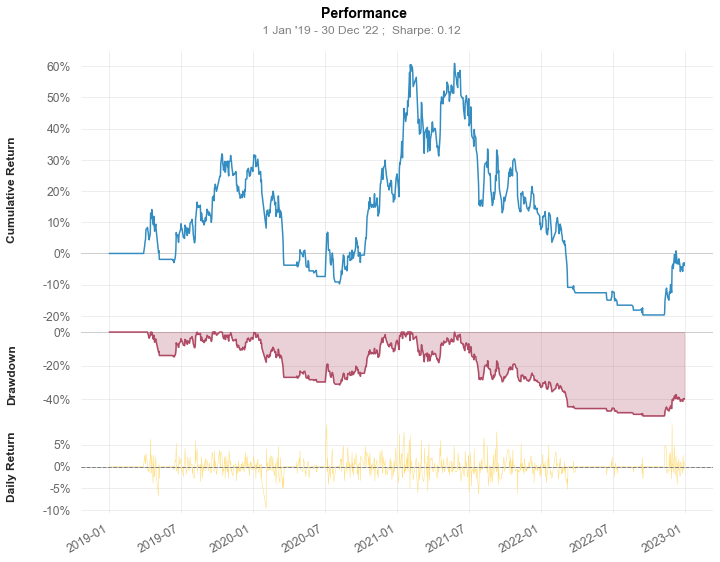

,策略,基准,超额
总收益,-2.98%,41.93%,-31.64%
年化收益率,-0.52%,6.24%,-6.36%
年化波动率,29.22%,21.93%,30.54%
夏普比率,0.12,0.52,-0.17
最大回撤,50.11%,31.57%,51.61%
最大回撤开始日期,2021-05-27,2021-09-14,2019-10-22
最大回撤截止日期,2022-12-30,2022-12-30,2022-12-30
月度胜率,52.38%,56.25%,45.83%


,收益,基准收益,超额收益,夏普比率,基准夏普比率,超额夏普比率,最大回撤,基准最大回撤,超额最大回撤
2019,26.25%,27.49%,-0.97%,1.13,1.19,0.1,14.9%,21.65%,26.85%
2020,-2.99%,18.65%,-18.24%,0.05,0.82,-0.57,31.45%,15.24%,45.16%
2021,-10.96%,13.52%,-21.57%,-0.13,0.93,-0.51,33.13%,9.57%,43.12%
2022,-10.78%,-20.26%,11.89%,-0.43,-0.97,0.55,29.22%,28.83%,24.21%


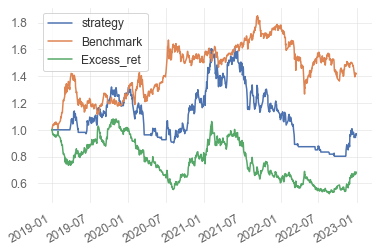

In [6]:
strategy = ManualStopOrStopTrail
strategy_params = {'trail':False, 'print_log':False}
start_date = '20190101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, strategy_params, stock_code, index_code,
         start_date, end_date,
         start_cash=1000000, report_mode='simple', price_type=None)

#### **动态止损法**

Using cache:  000001_20190101_20230101_bfq.csv
初始市值: 1000000.00
最终市值: 970563.00


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-04-01   2019-04-01
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       45.0%

Cumulative Return          5.71%        -2.94%
CAGR﹪                     1.03%        -0.55%

Sharpe                     0.18         0.06
Prob. Sharpe Ratio         63.3%        54.8%
Smart Sharpe               0.18         0.06
Sortino                    0.24         0.1
Smart Sortino              0.24         0.1
Sortino/√2                 0.17         0.07
Smart Sortino/√2           0.17         0.07
Omega                      1.02         1.02

Max Drawdown               -31.57%      -35.07%
Longest DD Days            473          1173
Volatility (ann.)          21.48%       20.82%
R^2                        0.04         0.04
Information Ratio          -0.01        -0.01
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-10-15,2022-09-26,2022-12-30,1173,-35.071554,-34.614789
2,2019-07-31,2019-09-17,2019-10-10,72,-12.020664,-11.025596
3,2019-04-22,2019-06-14,2019-06-19,59,-7.472208,-6.909697
4,2019-07-03,2019-07-11,2019-07-24,22,-4.309981,-4.175295
5,2019-04-09,2019-04-12,2019-04-15,7,-3.687640,-2.868164


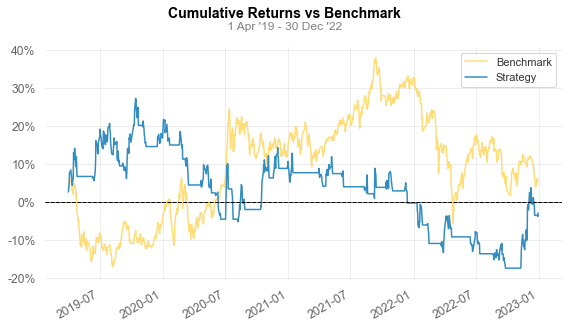

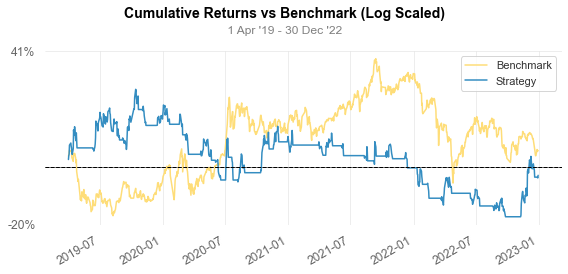

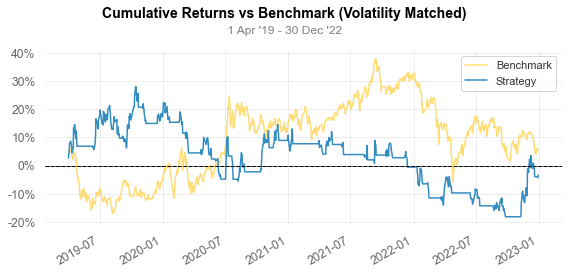

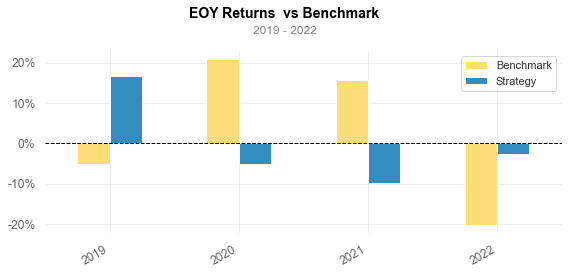

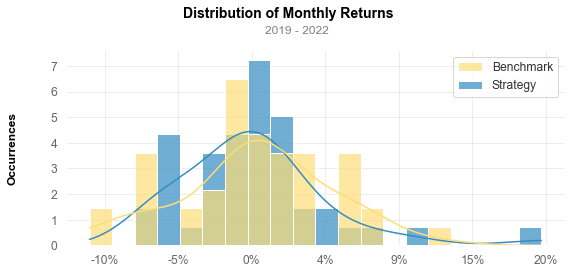

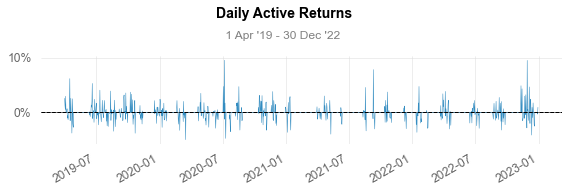

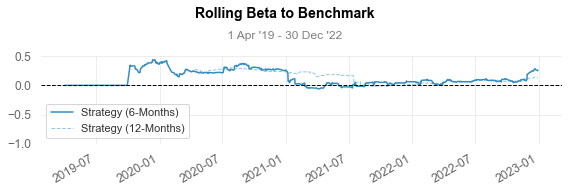

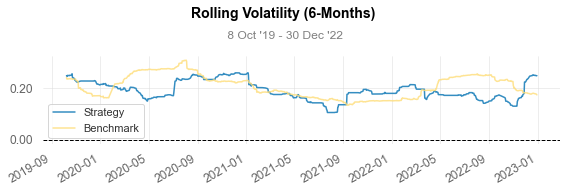

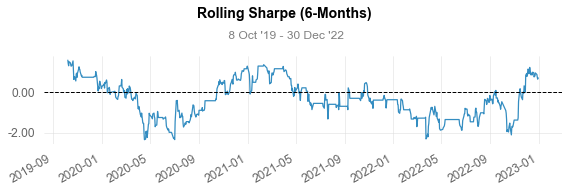

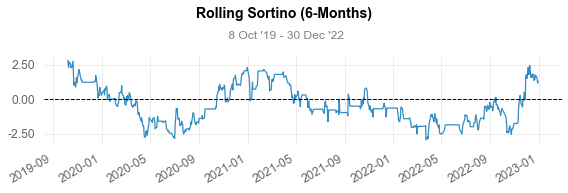

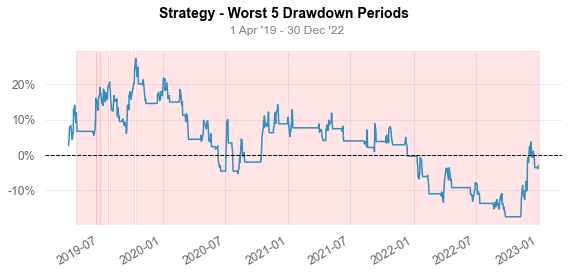

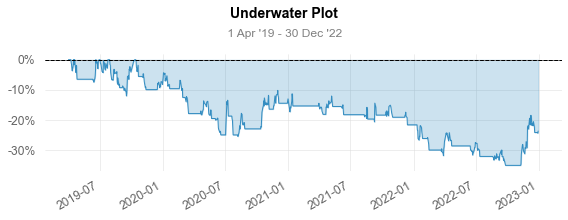

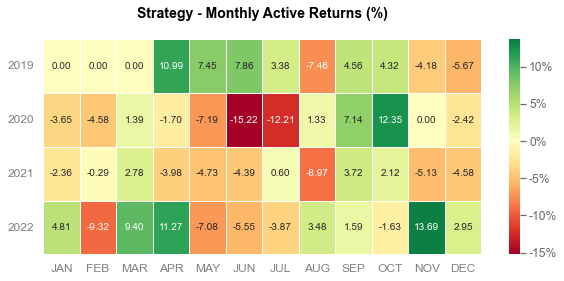

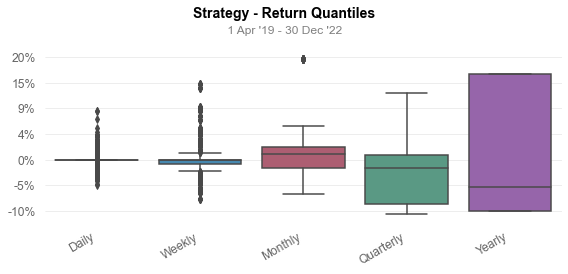

,策略,基准,超额
总收益,-2.94%,41.93%,-31.62%
年化收益率,-0.52%,6.24%,-6.36%
年化波动率,20.19%,21.93%,26.92%
夏普比率,0.06,0.52,-0.23
最大回撤,35.07%,31.57%,48.72%
最大回撤开始日期,2019-10-15,2021-09-14,2019-10-22
最大回撤截止日期,2022-12-30,2022-12-30,2022-12-30
月度胜率,46.15%,56.25%,45.83%


,收益,基准收益,超额收益,夏普比率,基准夏普比率,超额夏普比率,最大回撤,基准最大回撤,超额最大回撤
2019,16.75%,27.49%,-8.42%,0.91,1.19,-0.21,12.02%,21.65%,26.85%
2020,-7.49%,18.65%,-22.03%,-0.26,0.82,-0.74,22.12%,15.24%,39.8%
2021,-6.51%,13.52%,-17.65%,-0.35,0.93,-0.81,11.61%,9.57%,25.39%
2022,-2.62%,-20.26%,22.12%,-0.02,-0.97,0.86,17.17%,28.83%,24.42%


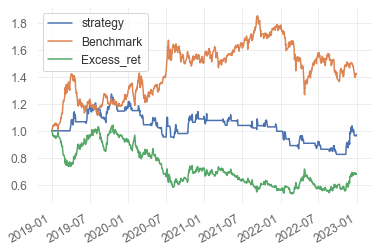

In [7]:
strategy = ManualStopOrStopTrail
strategy_params = {'trail':True, 'print_log':False}
start_date = '20190101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, strategy_params, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='full', price_type=None)

### **写法二**

In [8]:
class ManualStopOrStopTrailCheat(BaseStrategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False,
        pos_per=0.95,
    )

    def __init__(self):
        super().__init__()
        self.broker.set_coc(True)

    def notify_order(self, order):
        if not order.status == order.Completed:
            return  # discard any other notification

        if not self.position:  # we left the market
            if self.p.print_log:
                print('SELL@price: {:.2f}'.format(order.executed.price))
            return
        # 订单完成
        if self.p.print_log:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('买单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, order.executed.size, order.executed.price * order.executed.size))

                elif order.issell():
                    self.log('卖单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                    order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))

            else:
                self.log('订单作废 %s, %s, isbuy=%i' %
                         (order.data._name, order.getstatusname(), order.isbuy()))

    def next(self):
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        
        if not self.position and self.crossup > 0:
            size = int(self.broker.getvalue() * self.p.pos_per / self.datas[0].open[1] // 100 * 100)  # 股数
            self.buy(size=size)
            
            # 买入之后立刻跟上一个（条件）卖单（止损单）
            if not self.p.trail:
                stop_price = self.data.close[0] * (1.0 - self.p.stop_loss)
                self.sell(size=size, exectype=bt.Order.Stop, price=stop_price)
            else:
                self.sell(size=size, exectype=bt.Order.StopTrail,
                          trailamount=1)

#### **固定止损法**

Using cache:  000001_20190101_20230101_bfq.csv
初始市值: 1000000.00
最终市值: 972306.34


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-04-01   2019-04-01
End Period          2022-12-30   2022-12-30
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       78.0%

Cumulative Return   5.71%        -2.77%
CAGR﹪              1.03%        -0.52%

Sharpe              0.18         0.12
Prob. Sharpe Ratio  63.3%        59.41%
Sortino             0.24         0.19
Sortino/√2          0.17         0.13
Omega               1.02         1.02

Max Drawdown        -31.57%      -49.2%
Longest DD Days     473          583

Gain/Pain Ratio     0.03         0.02
Gain/Pain (1M)      0.17         0.11

Payoff Ratio        0.89         1.07
Profit Factor       1.03         1.02
Common Sense Ratio  0.93         1.22
CPC Index           0.49         0.5
Tail Ratio          0.9          1.19
Outlier Win Ratio   4.95         4.34
Outlier Loss Ratio  4.44         3.14

MTD                 -4.74%       0.96%
3M             

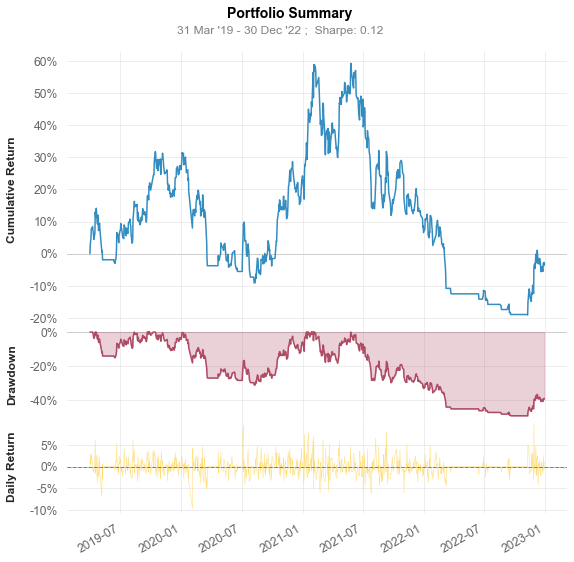

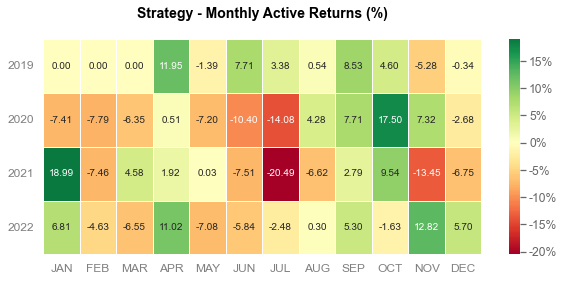

,策略,基准,超额
总收益,-2.77%,41.93%,-31.49%
年化收益率,-0.48%,6.24%,-6.33%
年化波动率,29.38%,21.93%,30.61%
夏普比率,0.12,0.52,-0.17
最大回撤,49.2%,31.57%,51.11%
最大回撤开始日期,2021-05-27,2021-09-14,2019-10-22
最大回撤截止日期,2022-12-30,2022-12-30,2022-12-30
月度胜率,52.38%,56.25%,47.92%


,收益,基准收益,超额收益,夏普比率,基准夏普比率,超额夏普比率,最大回撤,基准最大回撤,超额最大回撤
2019,26.11%,27.49%,-1.08%,1.13,1.19,0.09,15.08%,21.65%,26.85%
2020,-3.86%,18.65%,-18.97%,0.02,0.82,-0.59,30.86%,15.24%,44.69%
2021,-10.95%,13.52%,-21.56%,-0.13,0.93,-0.51,33.1%,9.57%,43.1%
2022,-9.68%,-20.26%,13.26%,-0.38,-0.97,0.6,27.95%,28.83%,23.58%


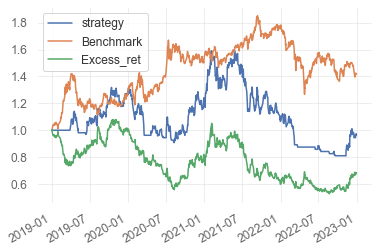

In [9]:
strategy = ManualStopOrStopTrailCheat
strategy_params = {'trail':False, 'print_log':False}
start_date = '20190101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, strategy_params, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

#### **动态止损法**

Using cache:  000001_20190101_20230101_bfq.csv
初始市值: 1000000.00
最终市值: 983319.00


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-04-01   2019-04-01
End Period          2022-12-30   2022-12-30
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       45.0%

Cumulative Return   5.71%        -1.67%
CAGR﹪              1.03%        -0.31%

Sharpe              0.18         0.08
Prob. Sharpe Ratio  63.3%        56.17%
Sortino             0.24         0.13
Sortino/√2          0.17         0.09
Omega               1.02         1.02

Max Drawdown        -31.57%      -34.68%
Longest DD Days     473          1173

Gain/Pain Ratio     0.03         0.02
Gain/Pain (1M)      0.17         0.08

Payoff Ratio        0.87         1.15
Profit Factor       1.03         1.02
Common Sense Ratio  0.93         1.1
CPC Index           0.47         0.53
Tail Ratio          0.9          1.08
Outlier Win Ratio   4.22         9.08
Outlier Loss Ratio  3.62         2.76

MTD                 -4.74%       -2.3%
3M           

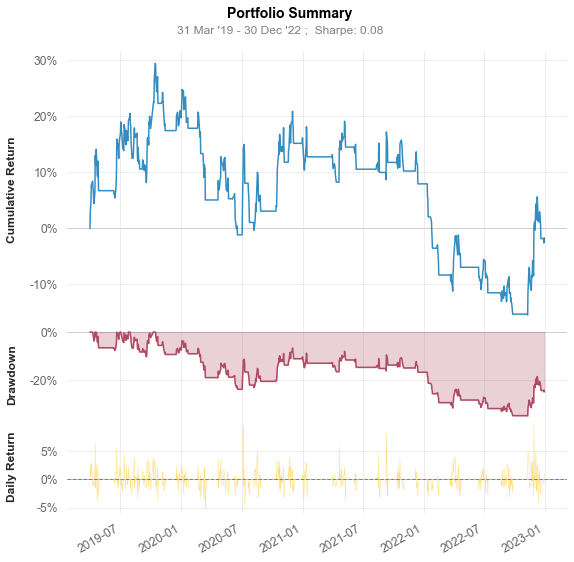

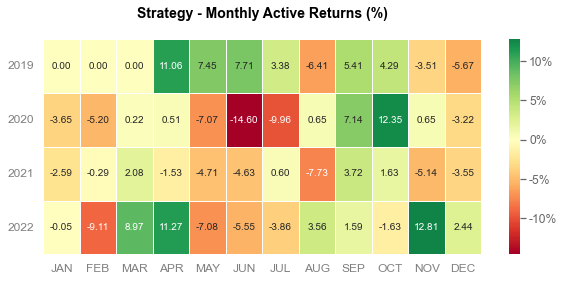

,策略,基准,超额
总收益,-1.67%,41.93%,-30.72%
年化收益率,-0.29%,6.24%,-6.15%
年化波动率,20.32%,21.93%,27.17%
夏普比率,0.08,0.52,-0.22
最大回撤,34.68%,31.57%,48.14%
最大回撤开始日期,2019-10-15,2021-09-14,2019-10-22
最大回撤截止日期,2022-12-30,2022-12-30,2022-12-30
月度胜率,51.28%,56.25%,45.83%


,收益,基准收益,超额收益,夏普比率,基准夏普比率,超额夏普比率,最大回撤,基准最大回撤,超额最大回撤
2019,19.74%,27.49%,-6.08%,1.04,1.19,-0.11,10.25%,21.65%,26.85%
2020,-5.29%,18.65%,-20.18%,-0.14,0.82,-0.62,20.78%,15.24%,37.91%
2021,-3.53%,13.52%,-15.02%,-0.14,0.93,-0.64,9.38%,9.57%,23.3%
2022,-8.91%,-20.26%,14.23%,-0.35,-0.97,0.63,21.67%,28.83%,24.35%


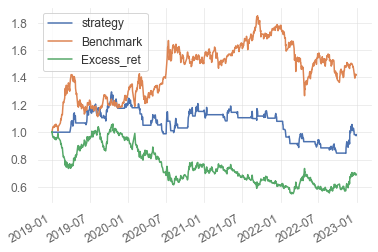

In [10]:
strategy = ManualStopOrStopTrailCheat
strategy_params = {'trail':True, 'print_log':False}
start_date = '20190101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, strategy_params, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

## **4.一揽子订单——实现止盈止损单**

#### 实现止盈止损单，同时给止盈止损一个期限

#### **self.buy_bracket**

In [11]:
class Bracket(BaseStrategy):
    params = dict(
        stop_loss=0.1,  # price is 10% less than the entry point
        stop_profit=0.1,
        pos_per=0.95,
        
        pentry=0.015,
        valid=10,
        wait_days=10,
    )

    def __init__(self):
        super().__init__()
        
        self.o = dict()  # orders per data (main, stop, limit, manual-close)
        self.holding = dict()  # holding periods per data

    def notify_order(self, order):
        if order.status == order.Submitted:
            return

        dt, dn = self.datetime.date(), order.data._name
        print('{} {} 订单 {} 状态 {}'.format(
            dt, dn, order.ref, order.getstatusname())
        )

        whichord = ['main', 'stop', 'limit', 'close']
        if not order.alive():  # not alive - nullify
            dorders = self.o[order.data]
            idx = dorders.index(order)
            dorders[idx] = None
            print('-- 订单结束 {} Ref'.format(whichord[idx]))

            if all(x is None for x in dorders):
                dorders[:] = []  # empty list - New orders allowed

    def next(self):
        d = self.data
        
        date, dn = self.datetime.date(), d._name
        pos = self.getposition(d).size
        # print('{} {} 仓位： {}, 订单状态管理：{}'.format(date, dn, pos, self.o.get(d, None)))
        
        if not pos and not self.o.get(d, None) and self.crossup > 0:
            print('-----------------------------{} {} 准备买入'.format(date, dn))
            p = d.close[0] * (1.0 - self.p.pentry)
            pstp = p * (1.0 - self.p.stop_loss)
            plmt = p * (1.0 + self.p.stop_profit)
            valid = timedelta(self.p.valid)
            size = int(self.broker.getvalue() * self.p.pos_per / p // 100 * 100)  
            
            """
            self.buy_bracket中有三个订单要设置：
            主订单buy，默认为限价单Limit，需要设置一个主限价单price参数
            子卖单sell，用于止损，默认为停止单Stop，限制损失，需要设置stopprice参数
            子卖单sell，用于止盈，默认为限价单Limit，到达盈利点后自动离场，需要设置limitprice参数
            
            其中的价格可能的一个设置为： 10元入场price，设置Stop为9.5元，止盈Limit为10元
            注意：这3个订单是一同存活的，同时，取消了其中一个，另外的也会自动取消
            
            该函数会返回一个列表，列表顺序为[主订单，停止单，止盈单]
            """
            self.o[d] = self.buy_bracket(
                                data=d,size=size, 
                                price=p, 
                                stopprice=pstp,
                                limitprice=plmt, oargs=dict(valid=valid)
            )

            print('{} {} 主订单号 {} 止损单号 {} 止盈单号 {}'.format(
                date, dn, *(x.ref for x in self.o[d])))
            
            self.holding[d] = 0
        elif pos:
            self.holding[d] += 1
            
            # 这里单纯使用了止盈止损，当然，也可以加入自己的卖出信号
            # if self.holding[d] >= self.p.wait_days or self.crossup[0] <= 0:
            if self.holding[d] >= self.p.wait_days:
                print('=============={} {} 超过时间，准备卖出 {}, {}, {}'.format(date, dn, self.holding[d], self.p.wait_days, self.crossup[0]))
                o = self.close(data=d)
                self.o[d].append(o)  # manual order to list of orders
                print('{} {} 手动平仓 {}'.format(date, dn, o.ref))
                self.cancel(self.o[d][1])  # 这里取消掉停止单Stop，其余订单会自动取消
                print('{} {} Cancel {}'.format(date, dn, self.o[d][1]))

Using cache:  000001_20190101_20230101_bfq.csv
初始市值: 1000000.00
-----------------------------2019-03-29 stock 准备买入
2019-03-29 stock 主订单号 175 止损单号 176 止盈单号 177
2019-04-01 stock 订单 175 状态 Accepted
2019-04-01 stock 订单 176 状态 Accepted
2019-04-01 stock 订单 177 状态 Accepted
2019-04-09 stock 订单 175 状态 Expired
-- 订单结束 main Ref
2019-04-09 stock 订单 176 状态 Canceled
-- 订单结束 stop Ref
2019-04-09 stock 订单 177 状态 Canceled
-- 订单结束 limit Ref
-----------------------------2019-06-11 stock 准备买入
2019-06-11 stock 主订单号 178 止损单号 179 止盈单号 180
2019-06-12 stock 订单 178 状态 Accepted
2019-06-12 stock 订单 179 状态 Accepted
2019-06-12 stock 订单 180 状态 Accepted
2019-06-12 stock 订单 178 状态 Completed
-- 订单结束 main Ref
2019-06-20 stock 订单 180 状态 Completed
-- 订单结束 limit Ref
2019-06-20 stock 订单 179 状态 Canceled
-- 订单结束 stop Ref
2019-06-20, 日期：20190620, 交易完毕, stock, 毛收益 94947.11, 扣佣后收益  94947.11, 佣金 0.00, 市值 1094947.10
-----------------------------2019-07-12 stock 准备买入
2019-07-12 stock 主订单号 181 止损单号 182 止盈单号 183
2019-07-15 stock 订单 18

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-06-12   2019-06-12
End Period          2022-12-30   2022-12-30
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       25.0%

Cumulative Return   19.65%       13.79%
CAGR﹪              3.55%        2.54%

Sharpe              0.36         0.33
Prob. Sharpe Ratio  74.3%        73.69%
Sortino             0.47         0.55
Sortino/√2          0.34         0.39
Omega               1.13         1.13

Max Drawdown        -31.57%      -20.38%
Longest DD Days     473          639

Gain/Pain Ratio     0.06         0.13
Gain/Pain (1M)      0.37         0.28

Payoff Ratio        0.84         0.99
Profit Factor       1.06         1.13
Common Sense Ratio  0.94         0.95
CPC Index           0.48         0.55
Tail Ratio          0.88         0.84
Outlier Win Ratio   3.78         18.38
Outlier Loss Ratio  3.54         3.02

MTD                 -4.74%       1.59%
3M           

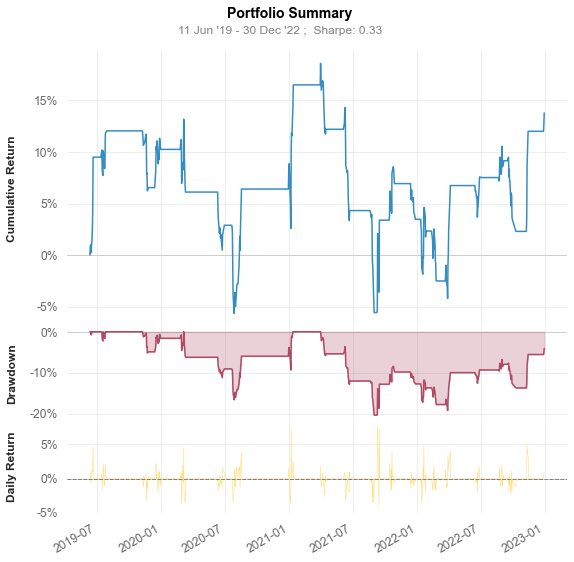

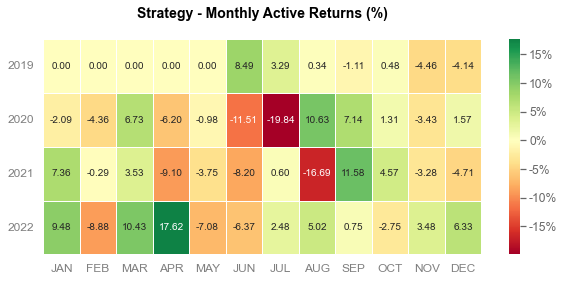

,策略,基准,超额
总收益,13.79%,41.93%,-19.83%
年化收益率,2.26%,6.24%,-3.75%
年化波动率,13.44%,21.93%,24.43%
夏普比率,0.32,0.52,-0.11
最大回撤,20.38%,31.57%,48.98%
最大回撤开始日期,2021-04-01,2021-09-14,2019-08-12
最大回撤截止日期,2022-12-30,2022-12-30,2022-12-30
月度胜率,53.57%,56.25%,50.0%


,收益,基准收益,超额收益,夏普比率,基准夏普比率,超额夏普比率,最大回撤,基准最大回撤,超额最大回撤
2019,10.25%,27.49%,-13.52%,1.19,1.19,-0.52,5.2%,21.65%,29.95%
2020,-1.27%,18.65%,-16.79%,-0.06,0.82,-0.63,16.63%,15.24%,36.09%
2021,-1.36%,13.52%,-13.11%,0.01,0.93,-0.51,20.38%,9.57%,35.34%
2022,9.97%,-20.26%,37.91%,0.8,-0.97,1.47,8.43%,28.83%,19.36%


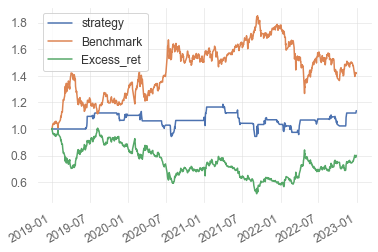

In [12]:
strategy = Bracket
strategy_params = {'print_log':True}
start_date = '20190101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, strategy_params, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)